In [ ]:
!pip install git+https://github.com/chrisjbryant/errant
!python -m spacy download en_core_web_sm

  Cloning https://github.com/chrisjbryant/errant to /tmp/pip-req-build-ocgimbvm
  Running command git clone --filter=blob:none --quiet https://github.com/chrisjbryant/errant /tmp/pip-req-build-ocgimbvm
  Resolved https://github.com/chrisjbryant/errant to commit 4a36d9bf7fa1d6109bea79b23fccc5d7731fabc1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.2 MB/s eta 0:00:00
  Created wheel for errant: filename=errant-3.0.0-py3-none-any.whl size=499358 sha256=e6ceb5e95bdde054286ab916155f4846274ac8d380650cc3f3cf50c02d8f6508
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ucgwuht/wheels/0b/8f/f4/c6d4ee59d3ffb4f343b9bd0fee22df4aeb571e6fd98319c781
Successfully built errant
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to re

# 🧠 Grammar Error Correction for Speech-to-Text: Project Framework

This project is focused on building a **Grammar Error Correction (GEC)** system tailored specifically for **Speech-to-Text (STT)** outputs. We design and compare three dataset processing strategies to achieve high-quality correction aligned with natural spoken grammar errors.

---

## 📐 General Framework



### 📊 Grammar Error Correction Framework (STT)

| **Stage**        | **Action**                                                                                                                                 |
|------------------|--------------------------------------------------------------------------------------------------------------------------------------------|
| **Dataset 1**    | Kaggle GEC (2000+ rows, no labels) + JFLEG (700 rows)                                                                                      |
|                  | → Apply `ERRANT` toolkit → Get `error_type` annotation                                                                                     |
|                  | → Combine into unified `input`, `target`, `error_type` dataset                                                                             |
| **Dataset 2**    | Train classifier on Kaggle → Predict `error_type` for JFLEG (`shadow labeling`)                                                           |
|                  | → Merge both datasets with predicted labels                                                                                                |
| **Dataset 3**    | Use Kaggle dataset only                                                                                                                    |
|                  | → Filter only relevant `error_type` for speech-to-text (Verb Tense, Article, SVA, etc.)                                                   |
| **Preprocessing**| Clean text, lowercase, remove noise                                                                                                        |
|                  | → Filter relevant STT error types                                                                                                          |
| **Balancing**    | Apply oversampling / class weighting                                                                                                       |
|                  | → Ensure balanced `error_type` distribution before training                                                                                |
| **Training**     | Train model (e.g. Logistic Regression, Random Forest, or Transformer-based model)                                                         |
|                  | → Input: `input` sentence | Output: `error_type` classifier or `target` sentence generator (seq2seq)                                       |


# Skenario 1


# Hapus fitur error type pada dataset Kaggle (Grammar Correction) dan gabungkan dataset tersebut pada jfleg_validation (tak berlabel error type)

In [ ]:
import pandas as pd

# Load the datasets
grammar_correction_df = pd.read_csv('Grammar Correction.csv')
jfleg_validation_df = pd.read_csv('jfleg_validation.csv')

# Rename columns in Grammar Correction.csv
grammar_correction_df = grammar_correction_df.rename(columns={
    'Ungrammatical Statement': 'input',
    'Standard English': 'target',
    'Error Type': 'error type'
})

# Save the modified Grammar Correction dataset
grammar_correction_df.to_csv('grammar_correction_processed.csv', index=False)

# Drop the 'error type' column
grammar_correction_df = grammar_correction_df.drop(columns=['error type'])


# Concatenate the two dataframes
# Make sure both dataframes have the same columns ('input', 'target') before concatenating
# We drop 'error type' from grammar_correction_df, so we only keep 'input' and 'target'
# We assume jfleg_validation_df already has or is renamed to have 'input' and 'target'
combined_df = pd.concat([grammar_correction_df[['input', 'target']], jfleg_validation_df[['input', 'target']]], ignore_index=True)

# Save the combined dataset
combined_df.to_csv('grammar_correction_combined_dataset.csv', index=False)

# Lakukan ERRANT

In [ ]:
import pandas as pd
import spacy
import errant
from tqdm import tqdm

# Load SpaCy + ERRANT
nlp = spacy.load("en_core_web_sm")
annotator = errant.load("en")

# Load CSV hasil gabungan
df = pd.read_csv("grammar_correction_combined_dataset.csv")


# Proses semua pasangan input → target
results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    src = str(row['input'])
    tgt = str(row['target'])
    try:
        src_doc = nlp(src)
        tgt_doc = nlp(tgt)
        edits = annotator.annotate(src_doc, tgt_doc)
        for e in edits:
            results.append({
                'input': src,
                'target': tgt,
                'original_word': e.o_str,
                'corrected_word': e.c_str,
                'error_type': e.type
            })
    except:
        continue

# Simpan hasil ke CSV
df_edits = pd.DataFrame(results)
df_edits.to_csv("errant_labeled_errors.csv", index=False)
print("✅ Saved: errant_labeled_errors.csv")

100%|██████████| 2770/2770 [01:10<00:00, 39.07it/s]

✅ Saved: errant_labeled_errors.csv


In [ ]:
df_new = pd.read_csv("errant_labeled_errors.csv")
df_new

,input,target,original_word,corrected_word,error_type
0,I goes to the store everyday.,I go to the store everyday.,goes,go,R:VERB:SVA
1,They was playing soccer last night.,They were playing soccer last night.,was,were,R:VERB:SVA
2,She have completed her homework.,She has completed her homework.,have,has,R:VERB:SVA
3,He don't know the answer.,He doesn't know the answer.,do,does,R:VERB:SVA
4,The sun rise in the east.,The sun rises in the east.,rise,rises,R:VERB:SVA
...,...,...,...,...,...
5453,While the communities in general have reckoned...,The communities in general have reckoned that ...,but,they,R:OTHER
5454,While the communities in general have reckoned...,The communities in general have reckoned that ...,have made,make,R:VERB:TENSE
5455,While the communities in general have reckoned...,The communities in general have reckoned that ...,an appeal of it in,NaN,U:OTHER
5456,While the communities in general have reckoned...,The communities in general have reckoned that ...,reaonable,reasonable,R:SPELL


# Visualisasi kelas error type

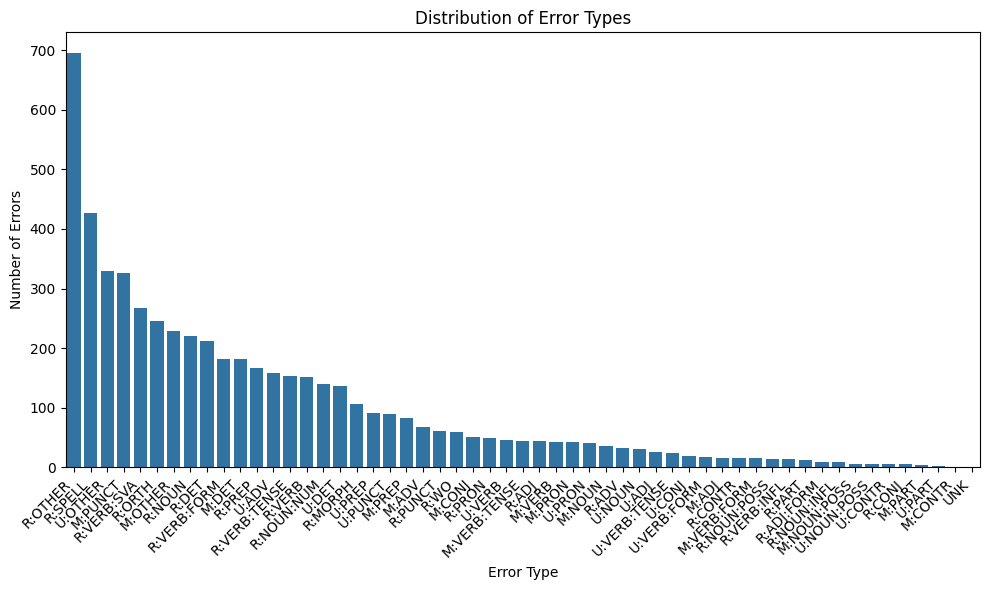

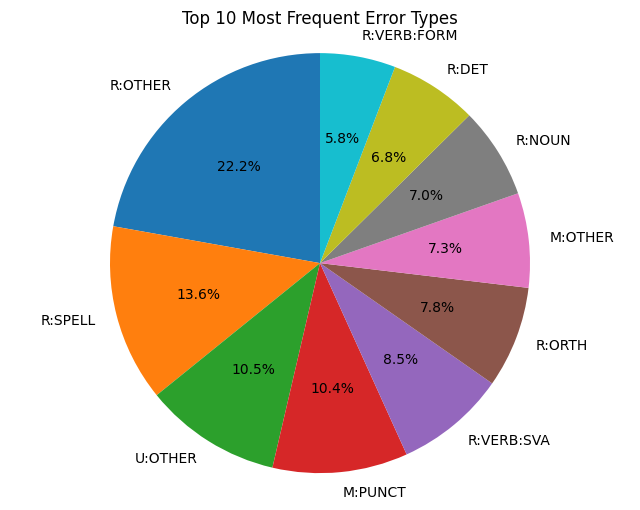

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each error type
error_counts = df_new['error_type'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=error_counts.index, y=error_counts.values)
plt.xlabel("Error Type")
plt.ylabel("Number of Errors")
plt.title("Distribution of Error Types")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


# Visualize the top 10 most frequent errors
top_10_errors = error_counts.head(10)
plt.figure(figsize=(8, 6))
plt.pie(top_10_errors, labels=top_10_errors.index, autopct='%1.1f%%', startangle=90)
plt.title("Top 10 Most Frequent Error Types")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Seleksi kelas error type yang relevan untuk speech to text


### 📌 Penjelasan Label Grammar dari ERRANT

| **Label**              | **Makna / Contoh Kesalahan Grammar** |
|------------------------|--------------------------------------|
| `R:VERB:SVA`           | Subject-Verb Agreement error<br>💬 *she go* → *she goes* |
| `R:DET`, `M:DET`       | Determiner salah/hilang<br>💬 *I eat apple* → *I eat an apple* |
| `R:PREP`, `M:PREP`     | Preposisi salah atau tidak ada<br>💬 *at Monday* → *on Monday* |
| `R:VERB:TENSE`         | Tense kata kerja salah<br>💬 *go yesterday* → *went yesterday* |
| `R:NOUN:NUM`           | Singular ↔ plural error<br>💬 *many cat* → *many cats* |
| `R:PRON`               | Pronoun salah<br>💬 *Me went* → *I went* |
| `R:ADJ` / `R:ADV`      | Adjective/adverb tidak sesuai<br>💬 *He run quick* → *He runs quickly* |
| `M:VERB`, `M:NOUN`     | Kata kerja atau noun hilang<br>💬 *I going* → *I am going* |

> ✅ Keterangan:
> - `R:` = Replace → ubah kata
> - `M:` = Missing → tambahkan kata yang hilang


In [ ]:
# Load uploaded ERRANT-labeled error data
df_errors = pd.read_csv("errant_labeled_errors.csv")

# Define relevant labels for grammar correction from STT
relevant_labels = [
    "R:VERB:TENSE", "R:VERB:SVA", "M:DET", "R:NOUN:NUM",
    "M:PREP", "R:PREP", "R:PRON", "R:ADJ", "R:ADV",
    "M:VERB", "M:NOUN", "R:DET"
]

# Filter based on relevant labels
df_filtered_errors = df_errors[df_errors["error_type"].isin(relevant_labels)].reset_index(drop=True)

# Save filtered result
filtered_output_path = "grammar_errors_filtered_for_stt.csv"
df_filtered_errors.to_csv(filtered_output_path, index=False)

filtered_output_path


'grammar_errors_filtered_for_stt.csv'

In [ ]:
df_new = pd.read_csv("grammar_errors_filtered_for_stt.csv")
df_new

,input,target,original_word,corrected_word,error_type
0,I goes to the store everyday.,I go to the store everyday.,goes,go,R:VERB:SVA
1,They was playing soccer last night.,They were playing soccer last night.,was,were,R:VERB:SVA
2,She have completed her homework.,She has completed her homework.,have,has,R:VERB:SVA
3,He don't know the answer.,He doesn't know the answer.,do,does,R:VERB:SVA
4,The sun rise in the east.,The sun rises in the east.,rise,rises,R:VERB:SVA
...,...,...,...,...,...
1403,There is many way for this another examples bo...,"There are many ways for this , another example...",examples,example,R:NOUN:NUM
1404,There is many way for this another examples bo...,"There are many ways for this , another example...",its,it,R:PRON
1405,There is many way for this another examples bo...,"There are many ways for this , another example...",colourful,colorful,R:ADJ
1406,It is because they do not think the new thing ...,It is because they do not think of new things ...,thing,things,R:NOUN:NUM


# Cek imbalance class

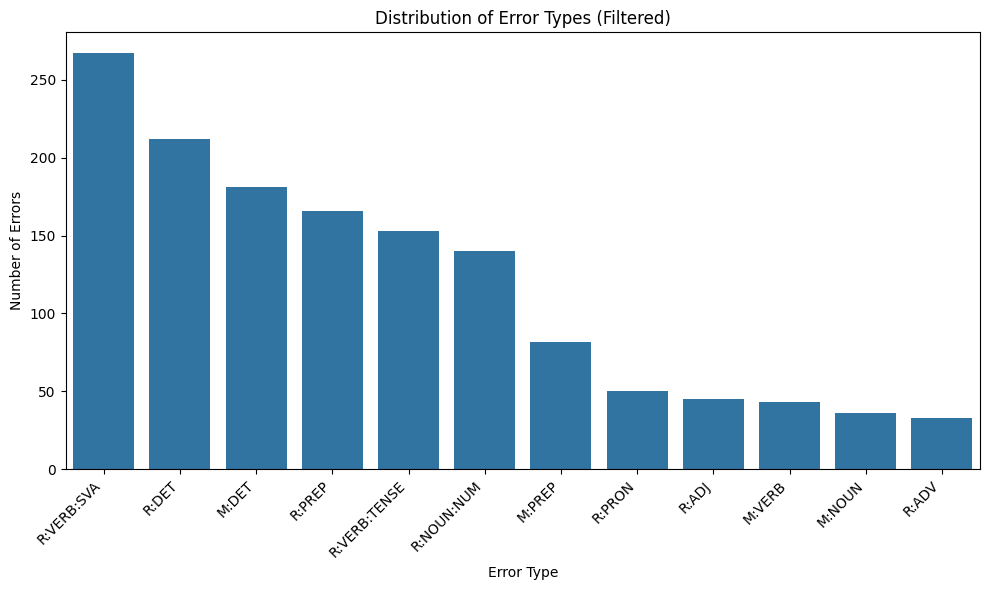

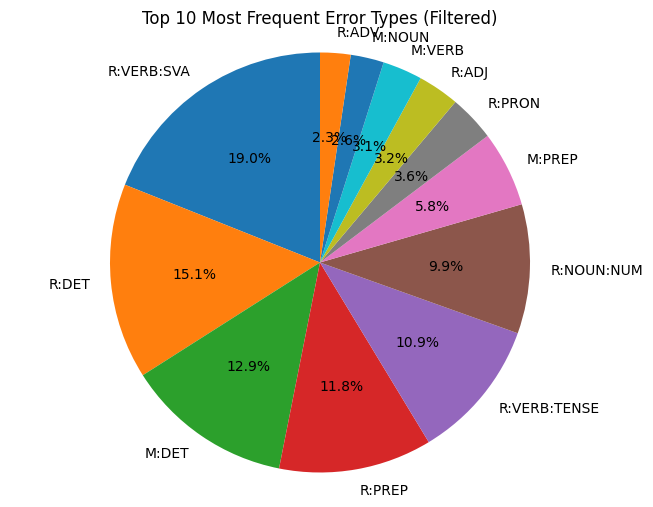

In [ ]:
# prompt: visualisasikan kelas error type

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the error data
df_errors = pd.read_csv("grammar_errors_filtered_for_stt.csv")

# Count the occurrences of each error type
error_counts = df_errors['error_type'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=error_counts.index, y=error_counts.values)
plt.xlabel("Error Type")
plt.ylabel("Number of Errors")
plt.title("Distribution of Error Types (Filtered)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

# Visualize the top 10 most frequent errors
top_10_errors = error_counts
plt.figure(figsize=(8, 6))
plt.pie(top_10_errors, labels=top_10_errors.index, autopct='%1.1f%%', startangle=90)
plt.title("Top 10 Most Frequent Error Types (Filtered)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Lakukan hybrid sampling untuk menangani imbalance dan visualisasikan

In [ ]:
# STEP 1: Install lib
!pip install pandas scikit-learn

# STEP 2: Import
import pandas as pd
from sklearn.utils import resample

# STEP 3: Load dataset (upload file dulu ke Colab atau gunakan path lokal)
df = pd.read_csv("grammar_errors_filtered_for_stt.csv")

# STEP 4: Cek distribusi awal label
label_counts = df['error_type'].value_counts()
print("Distribusi awal:\n", label_counts)

# STEP 5: Hybrid balancing
TARGET = 100  # target minimal per label (bisa kamu ubah)
balanced_dfs = []

for label in label_counts.index:
    df_label = df[df['error_type'] == label]
    current_len = len(df_label)

    if current_len < TARGET:
        # Oversample minor
        df_balanced = resample(df_label, replace=True, n_samples=TARGET, random_state=42)
    elif current_len > TARGET * 2:
        # Undersample mayor
        df_balanced = resample(df_label, replace=False, n_samples=TARGET * 2, random_state=42)
    else:
        # Biarkan jika sudah cukup seimbang
        df_balanced = df_label

    balanced_dfs.append(df_balanced)

# STEP 6: Gabungkan hasil
df_final = pd.concat(balanced_dfs).reset_index(drop=True)
print("Distribusi setelah balancing:\n", df_final['error_type'].value_counts())

# STEP 7: Simpan ke file CSV
df_final.to_csv("grammar_errors_hybrid_balanced.csv", index=False)
print("✅ Dataset tersimpan sebagai grammar_errors_hybrid_balanced.csv")


Distribusi awal:
 error_type
R:VERB:SVA      267
R:DET           212
M:DET           181
R:PREP          166
R:VERB:TENSE    153
R:NOUN:NUM      140
M:PREP           82
R:PRON           50
R:ADJ            45
M:VERB           43
M:NOUN           36
R:ADV            33
Name: count, dtype: int64
Distribusi setelah balancing:
 error_type
R:VERB:SVA      200
R:DET           200
M:DET           181
R:PREP          166
R:VERB:TENSE    153
R:NOUN:NUM      140
M:PREP          100
R:PRON          100
R:ADJ           100
M:VERB          100
M:NOUN          100
R:ADV           100
Name: count, dtype: int64
✅ Dataset tersimpan sebagai grammar_errors_hybrid_balanced.csv


In [ ]:
df_baru = pd.read_csv("grammar_errors_hybrid_balanced.csv")
df_baru

,input,target,original_word,corrected_word,error_type
0,The series of lectures on history was very inf...,The series of lectures on history were very in...,was,were,R:VERB:SVA
1,The audience was clapping their hands enthusia...,The audience were clapping their hands enthusi...,was,were,R:VERB:SVA
2,The movie am starting in five minutes.,The movie is starting in five minutes.,am,is,R:VERB:SVA
3,My 1 0th exam and 1 2th exam is very good .,My 1 0th exam and 1 2th exam are very good .,is,are,R:VERB:SVA
4,The flowers is growing in the garden.,The flowers are growing in the garden.,is,are,R:VERB:SVA
...,...,...,...,...,...
1635,The novel explores complex themes and presents...,The novel explores complex themes and presents...,super,quite,R:ADV
1636,"30. I can't stand the cold, it's way too frigg...","30. I can't stand the cold, it's much too cold.",way,much,R:ADV
1637,"30. I can't stand the cold, it's way too frigg...","30. I can't stand the cold, it's much too cold.",way,much,R:ADV
1638,Close-up video clips of a juicy hamburger flyi...,Close-up video clips of a juicy hamburger flyi...,surely,clearly,R:ADV


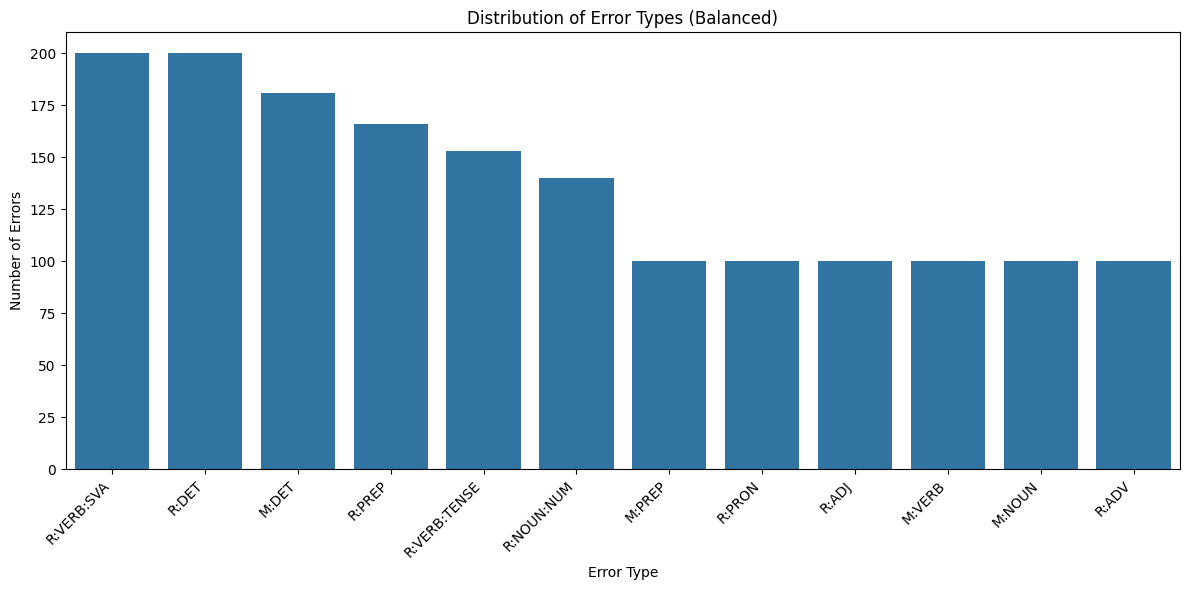

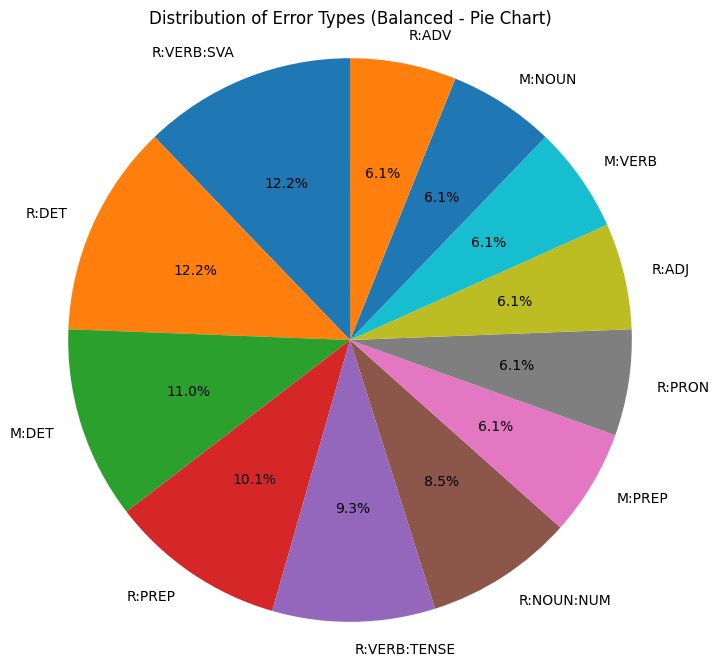

In [ ]:
# Load the balanced error data
df_balanced = pd.read_csv("grammar_errors_hybrid_balanced.csv")

# Count the occurrences of each error type in the balanced dataset
balanced_error_counts = df_balanced['error_type'].value_counts()

# Create a bar plot for the balanced dataset
plt.figure(figsize=(12, 6))
sns.barplot(x=balanced_error_counts.index, y=balanced_error_counts.values)
plt.xlabel("Error Type")
plt.ylabel("Number of Errors")
plt.title("Distribution of Error Types (Balanced)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Create a pie chart for the balanced dataset
plt.figure(figsize=(8, 8))
plt.pie(balanced_error_counts, labels=balanced_error_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Error Types (Balanced - Pie Chart)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Visualisasi ada berapa kata dalam satu kalimat pada dataset ini

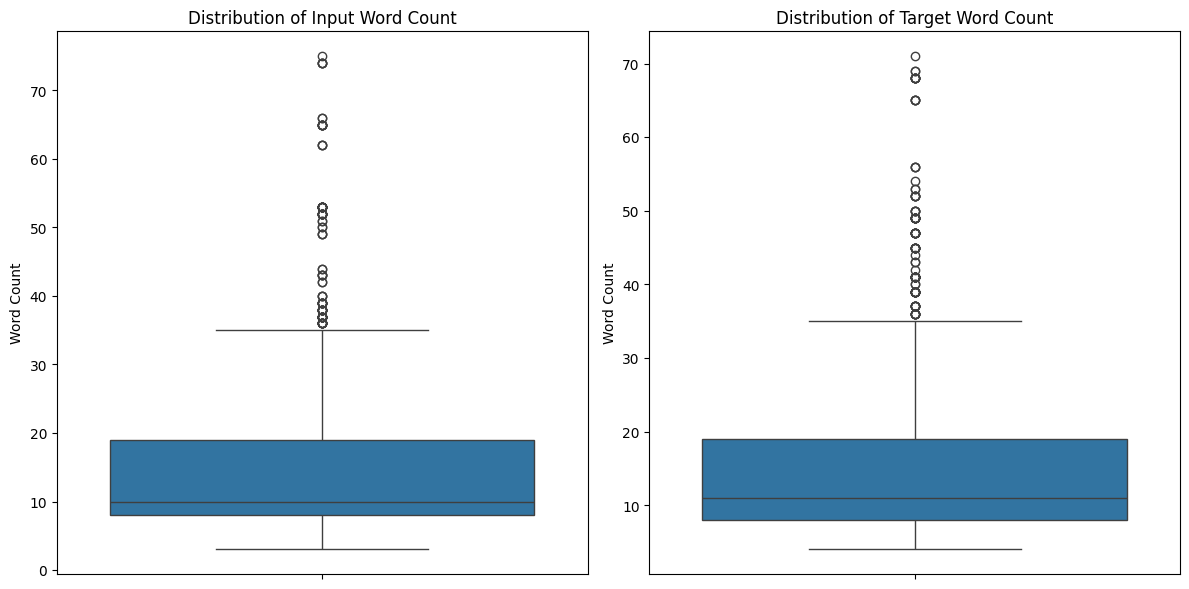

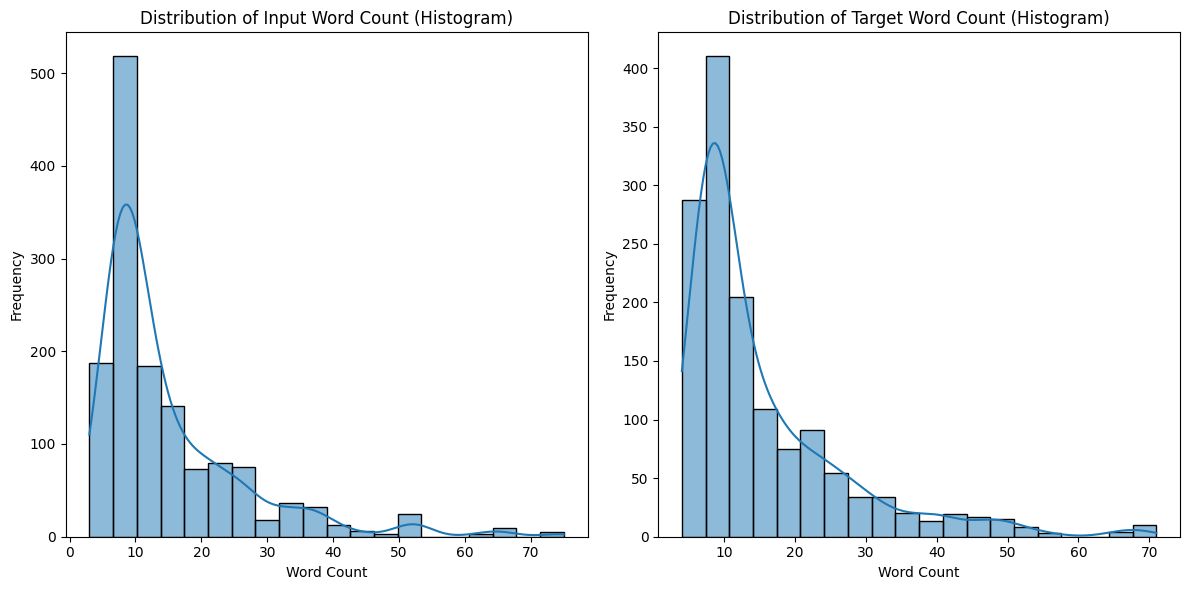

Summary statistics for Input Word Count:
count    1408.000000
mean       15.041193
std        11.515930
min         3.000000
25%         8.000000
50%        10.000000
75%        19.000000
max        75.000000
Name: input_word_count, dtype: float64

Summary statistics for Target Word Count:
count    1408.000000
mean       15.420455
std        11.533243
min         4.000000
25%         8.000000
50%        11.000000
75%        19.000000
max        71.000000
Name: target_word_count, dtype: float64


In [ ]:
# Calculate word counts
df['input_word_count'] = df['input'].apply(lambda x: len(str(x).split()))
df['target_word_count'] = df['target'].apply(lambda x: len(str(x).split()))

# Create box plots to visualize the distribution of word counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['input_word_count'])
plt.title('Distribution of Input Word Count')
plt.ylabel('Word Count')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['target_word_count'])
plt.title('Distribution of Target Word Count')
plt.ylabel('Word Count')

plt.tight_layout()
plt.show()

# Create histograms to visualize the distribution of word counts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['input_word_count'], bins=20, kde=True)
plt.title('Distribution of Input Word Count (Histogram)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['target_word_count'], bins=20, kde=True)
plt.title('Distribution of Target Word Count (Histogram)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary statistics for Input Word Count:")
print(df['input_word_count'].describe())
print("\nSummary statistics for Target Word Count:")
print(df['target_word_count'].describe())

# Memastikan hanya ada fitur input, target, dan error_type pada dataset

In [ ]:
# Ambil kolom yang relevan saja
df_output = df_final[['input', 'target', 'error_type']]

# Simpan ke file CSV
output_csv_path = "balanced_data_for_model.csv"
df_output.to_csv(output_csv_path, index=False)

print(f"✅ Data dengan kolom 'input', 'target', dan 'error_type' berhasil disimpan ke {output_csv_path}")

✅ Data dengan kolom 'input', 'target', dan 'error_type' berhasil disimpan ke balanced_data_for_model.csv


# Visualisasi banyak kata dalam satu kalimat untuk dataset jfleg_validation

Distribusi jumlah kata pada kolom 'input' di jfleg_validation.csv:
count    755.000000
mean      18.557616
std       10.139887
min        1.000000
25%       12.000000
50%       16.000000
75%       23.000000
max       80.000000
Name: input_word_count, dtype: float64


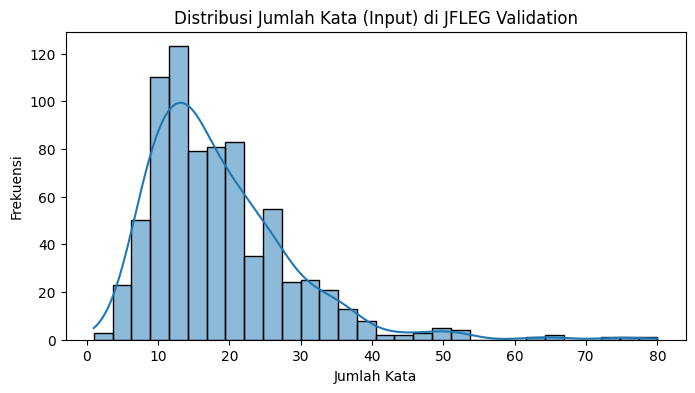


Distribusi jumlah kata pada kolom 'target' di jfleg_validation.csv:
count    755.000000
mean      18.862252
std       10.221141
min        1.000000
25%       12.000000
50%       17.000000
75%       24.000000
max       76.000000
Name: target_word_count, dtype: float64


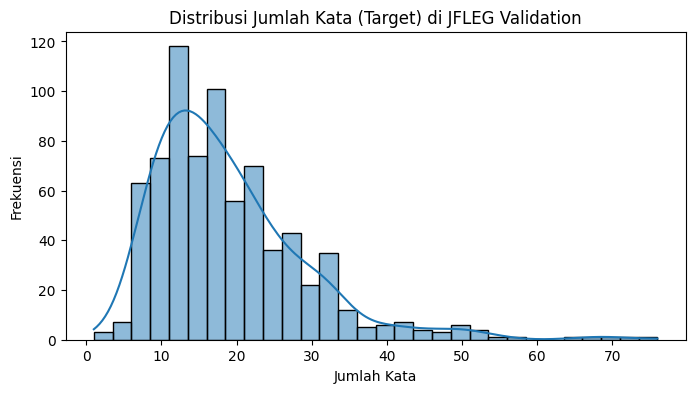

In [ ]:

# Load the JFLEG validation CSV
df_jfleg = pd.read_csv("/content/jfleg_validation.csv")

# Calculate word count for the input column (assuming the input sentence is in a column named 'input')
# If your column name is different, change 'input' below.
if 'input' in df_jfleg.columns:
  df_jfleg['input_word_count'] = df_jfleg['input'].apply(lambda x: len(str(x).split()))
  print("Distribusi jumlah kata pada kolom 'input' di jfleg_validation.csv:")
  print(df_jfleg['input_word_count'].describe())

  # Optional: Visualize the distribution
  plt.figure(figsize=(8, 4))
  sns.histplot(df_jfleg['input_word_count'], bins=30, kde=True)
  plt.title('Distribusi Jumlah Kata (Input) di JFLEG Validation')
  plt.xlabel('Jumlah Kata')
  plt.ylabel('Frekuensi')
  plt.show()

elif 'sentence' in df_jfleg.columns:
    # If the input column is named 'sentence'
    df_jfleg['sentence_word_count'] = df_jfleg['sentence'].apply(lambda x: len(str(x).split()))
    print("Distribusi jumlah kata pada kolom 'sentence' di jfleg_validation.csv:")
    print(df_jfleg['sentence_word_count'].describe())

    # Optional: Visualize the distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_jfleg['sentence_word_count'], bins=30, kde=True)
    plt.title('Distribusi Jumlah Kata (Sentence) di JFLEG Validation')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')
    plt.show()
else:
  print("Kolom 'input' atau 'sentence' tidak ditemukan di jfleg_validation.csv.")
  print("Pastikan nama kolom input sudah benar.")

# You can similarly analyze the 'target' column if it exists in jfleg_validation.csv
if 'target' in df_jfleg.columns:
    df_jfleg['target_word_count'] = df_jfleg['target'].apply(lambda x: len(str(x).split()))
    print("\nDistribusi jumlah kata pada kolom 'target' di jfleg_validation.csv:")
    print(df_jfleg['target_word_count'].describe())

    # Optional: Visualize the distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_jfleg['target_word_count'], bins=30, kde=True)
    plt.title('Distribusi Jumlah Kata (Target) di JFLEG Validation')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')
    plt.show()
elif 'corrected_sentence' in df_jfleg.columns:
     # If the target column is named 'corrected_sentence'
    df_jfleg['corrected_word_count'] = df_jfleg['corrected_sentence'].apply(lambda x: len(str(x).split()))
    print("\nDistribusi jumlah kata pada kolom 'corrected_sentence' di jfleg_validation.csv:")
    print(df_jfleg['corrected_word_count'].describe())

    # Optional: Visualize the distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df_jfleg['corrected_word_count'], bins=30, kde=True)
    plt.title('Distribusi Jumlah Kata (Corrected Sentence) di JFLEG Validation')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')
    plt.show()
else:
  print("\nKolom 'target' atau 'corrected_sentence' tidak ditemukan di jfleg_validation.csv.")
  print("Pastikan nama kolom target sudah benar.")

# Visualisasi banyak kata dalam satu kalimat untuk dataset Grammar Correction

Distribusi jumlah kata pada kolom 'input' di /content/Grammar Correction.csv:
count    2018.000000
mean        8.989098
std         2.520886
min         3.000000
25%         7.000000
50%         9.000000
75%        10.000000
max        22.000000
Name: input_word_count, dtype: float64

Distribusi jumlah kata pada kolom 'target' di /content/Grammar Correction.csv:
count    2018.000000
mean        8.725471
std         2.273111
min         2.000000
25%         7.000000
50%         9.000000
75%        10.000000
max        18.000000
Name: target_word_count, dtype: float64


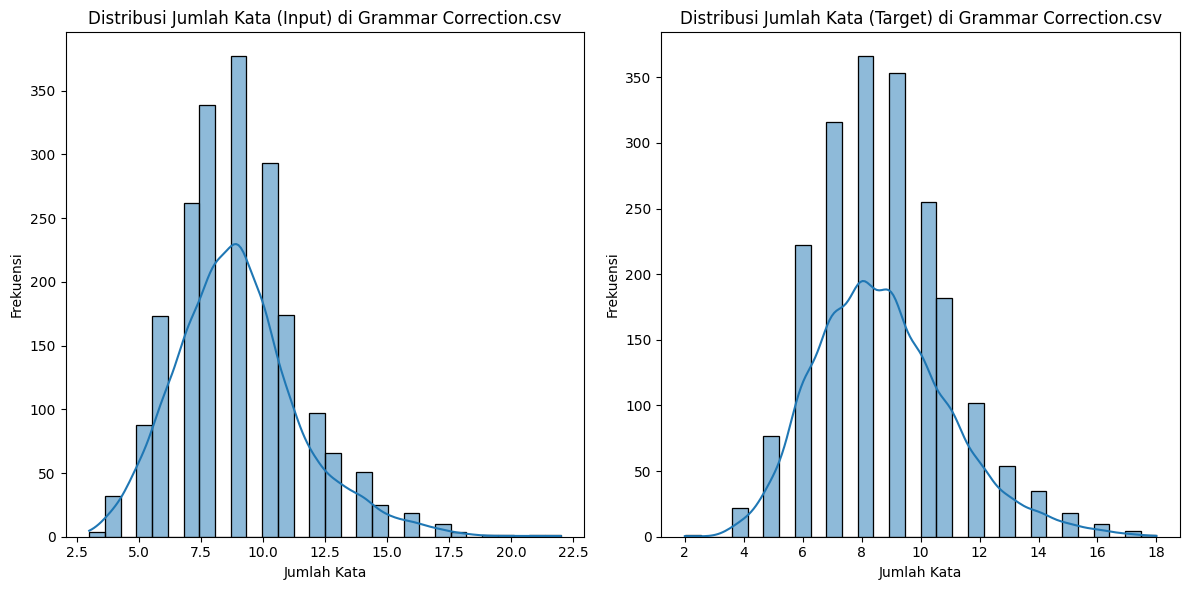

In [ ]:
# Load the combined dataset
df_combined = pd.read_csv("/content/Grammar Correction.csv")

# Rename the input column if it's named differently
if 'Ungrammatical Statement' in df_combined.columns:
    df_combined = df_combined.rename(columns={'Ungrammatical Statement': 'input'})

# Rename the target column if it's named differently
if 'Standard English' in df_combined.columns:
    df_combined = df_combined.rename(columns={'Standard English': 'target'})

# Add a check if 'input' still doesn't exist after potential renaming
if 'input' not in df_combined.columns:
    print("Error: 'input' column not found in the DataFrame. Available columns are:")
    print(df_combined.columns)
# Add a check if 'target' still doesn't exist after potential renaming
elif 'target' not in df_combined.columns:
     print("Error: 'target' column not found in the DataFrame. Available columns are:")
     print(df_combined.columns)
else:
    # Calculate word counts for both input and target columns
    df_combined['input_word_count'] = df_combined['input'].apply(lambda x: len(str(x).split()))
    df_combined['target_word_count'] = df_combined['target'].apply(lambda x: len(str(x).split()))

    # Print summary statistics for word counts
    print("Distribusi jumlah kata pada kolom 'input' di /content/Grammar Correction.csv:")
    print(df_combined['input_word_count'].describe())

    print("\nDistribusi jumlah kata pada kolom 'target' di /content/Grammar Correction.csv:")
    print(df_combined['target_word_count'].describe())

    # Optional: Visualize the distributions with histograms
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_combined['input_word_count'], bins=30, kde=True)
    plt.title('Distribusi Jumlah Kata (Input) di Grammar Correction.csv')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')

    plt.subplot(1, 2, 2)
    sns.histplot(df_combined['target_word_count'], bins=30, kde=True)
    plt.title('Distribusi Jumlah Kata (Target) di Grammar Correction.csv')
    plt.xlabel('Jumlah Kata')
    plt.ylabel('Frekuensi')

    plt.tight_layout()
    plt.show()